In [4]:
from IPython.core.display import HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%load_ext autoreload
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Author: Andrew Tarzia

Date Created: 11 Sep 2018

Distributed under the terms of the MIT License.

# Notebook to find new reactions from a set of EC numbers for enzymatic catalysis in ZIFs

In [5]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
from Bio import SeqIO
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from Bio.Alphabet import IUPAC
from rdkit.Chem.Draw import IPythonConsole  # to show molecules in notebook
import time
import numpy as np
import pandas as pd
# ensure cpickle usage
try:
    import cPickle as pickle
except ModuleNotFoundError:
    import pickle
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Descriptors
from rdkit.Chem.Descriptors3D import NPR1, NPR2, PMI1, PMI2, PMI3
from rdkit.Chem.Draw.MolDrawing import MolDrawing
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Geometry import rdGeometry
from rdkit.Chem import PyMol
from rdkit import Geometry
import tempfile
%aimport pi_fn
%aimport parameters
%aimport BRENDA_IO
%aimport SABIO_IO
%aimport rdkit_functions
%aimport ellipsoid
%aimport DB_functions
%aimport CHEBI_IO
%aimport BKMS_IO
%aimport KEGG_IO
%aimport Uniprot_IO
%aimport PUBCHEM_IO
%aimport rxn_syst

# Calculate pI of all sequences in EC No. used in literature
## Produces distribution for each EC No.

## Notes:
### Biopython:
- pK values and the methods are taken from::
    * Bjellqvist, B.,Hughes, G.J., Pasquali, Ch., Paquet, N., Ravier, F.,
    Sanchez, J.-Ch., Frutiger, S. & Hochstrasser, D.F.
    The focusing positions of polypeptides in immobilized pH gradients can be
    predicted from their amino acid sequences. Electrophoresis 1993, 14,
    1023-1031.
    * Bjellqvist, B., Basse, B., Olsen, E. and Celis, J.E.
    Reference points for comparisons of two-dimensional maps of proteins from
    different human cell types defined in a pH scale where isoelectric points
    correlate with polypeptide compositions. Electrophoresis 1994, 15, 529-539.

|  AA | pKa  |
|-----|------|
| ASP | 4.05 |
| GLU | 4.45 |
| HIS | 5.98 |
| CYS | 9.00 |
| TYR | 10.0 |
| LYS | 10.0 |
| ARG | 12.0 |
| N-terminus | 7.50 |
| N-terminus : GLU | 7.7 |
| N-terminus : VAL | 7.44 |
| N-terminus : THR | 6.82 |
| N-terminus : PRO | 8.36 |
| N-terminus : SER | 6.93 |
| N-terminus : MET | 7.00 |
| N-terminus : ALA | 7.59 |
| C-terminus | 3.55 |
| C-terminus : ASP | 4.55 |
| C-terminus : GLU | 4.75 |

- with the above pKas and the data set in Tash's paper (DOI:) we apply a pI cut off = XX.


### Modified pIs:
- assuming sequence only and therefore cannot use DSSP to calculate exposure

In [5]:
# get parameters
param_dict = parameters.get_parameters()

# input parameters
database_directory = '/home/atarzia/psp/screening_results/new_reactions/sequences/'
output_dir = database_directory

In [6]:
# get input FASTA file names
database_names = []
for i in glob.glob(database_directory+"*fasta"):
    if "_mod" not in i:
        database_names.append(i)
database_names = sorted(database_names)
print('databases:')
for i in database_names:
    print('--', i.replace(database_directory, ''))

# prepare output CSV file
redo_pi = input('redo pI calculation (True = yes, False = no)')
if redo_pi == 'True':
    redo_pi = True
    pi_fn.prepare_out_csv(output_dir, param_dict)
    # fix formatting of FASTA files to match BIOPYTHON readable
    pi_fn.fix_fasta(database_names)

databases:
-- 4__BRENDA_sequences.fasta
-- 5__BRENDA_sequences.fasta
redo pI calculation (True = yes, False = no)True


calculate all pIs for target EC sequences
doing: /home/atarzia/psp/screening_results/new_reactions/sequences/4__BRENDA_sequences.fasta
--- finished 1468675 sequences in 381.56 seconds ---
plot distribution of pIs
done
doing: /home/atarzia/psp/screening_results/new_reactions/sequences/5__BRENDA_sequences.fasta
--- finished 909334 sequences in 274.90 seconds ---
plot distribution of pIs
done


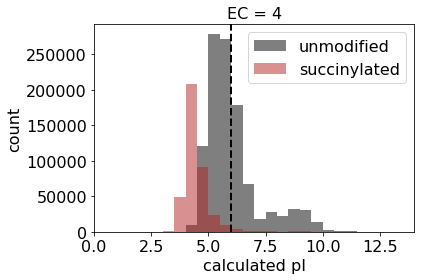

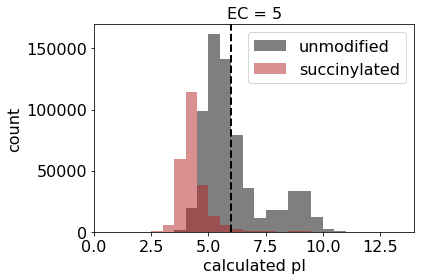

In [7]:
print('calculate all pIs for target EC sequences')
for EC_file in database_names:
    # read the file
    # but to avoid memory issues
    # we will calculate the pI on the fly
    # using the bio python module
    print('doing:', EC_file)
    file_mod = EC_file.replace(".fasta", "_mod.fasta")
    if redo_pi is True:
        pi_fn.calculate_pI_from_file(file_mod, param_dict, output_dir)
    print('plot distribution of pIs')
    pi_data = pd.read_csv(output_dir+param_dict['out_CSV_pi'], index_col=False)
    EC_pi_data = pi_data[pi_data['fasta_file'] == file_mod]
    pi_fn.plot_EC_pI_dist(EC_pi_data, param_dict,
                          filename=file_mod.replace('.fasta', '.pdf'),
                          title=file_mod.replace(output_dir, '').replace('__BRENDA_sequences_mod.fasta', ''))
    print('done')

# Collect reactant-product systems 
suggest new reactions!

### Collect all reaction systems from multiple databases
Online.

In [6]:
# set output directory
output_dir = '/home/atarzia/psp/screening_results/new_reactions/'

# set databases to search to collect reaction systems
# BKMS should always be last as the culmination of all DBs
Databases = ['BKMS', 'SABIO', 'BRENDA', 'KEGG', ]

# set EC numbers of interest
# get from a data file - manually made from https://enzyme.expasy.org/enzyme-byclass.html
EC_file = output_dir+'desired_EC.txt'
EC_DF = pd.read_table(EC_file, delimiter='__', names=['EC_no', 'description'], engine='python')
EC_int = list(EC_DF['EC_no'])

# csv file with molecular output
mol_output_file = output_dir+'screening_output.csv'
molecule_output = DB_functions.initialize_mol_output_DF(mol_output_file, overwrite=False)

In [7]:
print(len(EC_int), 'EC numbers to test')

1129 EC numbers to test


In [ ]:
for DB in Databases:
    # get database specific information
    DB_prop = DB_functions.get_DB_prop(DB)
    db_dir = DB_prop[0]
    # iterate over EC numbers of interest
    for EC in EC_int:
        rxn_syst.get_reaction_systems(EC, DB, output_dir, clean_system=False, verbose=False)

In [ ]:
# what percentage of reaction systems have skip_rxn = False
count = 0
react_syst_files = glob.glob(output_dir+'sRS-*.pkl')
for rs in rxn_syst.yield_rxn_syst(output_dir):
    if rs.skip_rxn is False:
        count += 1
        
print('-----------------------------------')
print(count, 'reaction systems of', len(react_syst_files), 'are NOT skipped.')
print('=>', round(count/len(react_syst_files), 4)*100, 'percent')
print('-----------------------------------')

### Check all reaction systems for if they fit through MOF
Not DB dependant.
Offline.

In [17]:
# get parameters
param_dict = parameters.get_parameters()
threshold = float(param_dict['diffuse_threshold'])
react_syst_files = glob.glob(output_dir+'sRS-*.pkl')

In [18]:
# iterate over reaction system files
count = 0
for rs in rxn_syst.yield_rxn_syst(output_dir):
    print('checking rxn', count, 'of', len(react_syst_files))
    count += 1
    if rs.skip_rxn is True:
        print('skipping reaction....')
        continue
    
    # define reactants and products dict
    # name: (smile, DB, DB_ID, iupac_name, role)
    components_dict = {}
    
    # ignore any reactions with unknown components
    rs.skip_rxn = False
    for m in rs.components:
        if m.mol is None:
            rs.skip_rxn = True
    
    if rs.skip_rxn is True:
        print('skipping reaction - it is incomplete or generic')
        rs.save_object(output_dir+rs.pkl)
        continue
    for m in rs.components:
        # get IUPAC NAME
        if m.iupac_name is None:
            m.cirpy_to_iupac()
        # remove reactions with general atoms (given by '*' in SMILES)
        if "*" in m.SMILES:
            rs.skip_rxn = True
            print('skipping reaction - it is incomplete or generic')
            rs.save_object(output_dir+rs.pkl)
            break
        components_dict[m.name] = (m.SMILES, m.DB, m.DB_ID, m.iupac_name, m.role.lower())
    
    # calculate molecule size of all components
    # save to molecule output files
    molecule_output = DB_functions.initialize_mol_output_DF(mol_output_file, overwrite=False)
    DB_functions.get_molecule_diameters(components_dict,
                                        molecule_output=molecule_output,
                                        mol_output_file=mol_output_file, out_dir=output_dir,
                                        vdwScale=0.8, boxMargin=4.0, 
                                        spacing=0.6, N_conformers=50, MW_thresh=250)
    
    molecule_output = DB_functions.initialize_mol_output_DF(mol_output_file, overwrite=False)
    
    # get diameters (should alrady be calculated) 
    # of all components of reaction
    rs.check_all_fit(threshold, molecule_output)
    
    # ignore any reactions with components with no sizes
    for m in rs.components:
        if m.mid_diam is None or m.mid_diam == 0:
            rs.skip_rxn = True
    rs.save_object(output_dir+rs.pkl)
    print('-----------------------------------')

checking rxn 0 of 16913
skipping reaction....
checking rxn 1 of 16913
doing calculation...
-----------------------------------
checking rxn 2 of 16913
skipping reaction....
checking rxn 3 of 16913
skipping reaction....
checking rxn 4 of 16913
skipping reaction - it is incomplete or generic
checking rxn 5 of 16913
skipping reaction....
checking rxn 6 of 16913
skipping reaction....
checking rxn 7 of 16913
skipping reaction....
checking rxn 8 of 16913
doing calculation...
delta 4-Androstene-3,17-dione molecule is too big - skipping....
doing calculation...
delta 5-Androstene-3,17-dione molecule is too big - skipping....
doing calculation...
Glutathione molecule is too big - skipping....
-----------------------------------
checking rxn 9 of 16913
skipping reaction....
checking rxn 10 of 16913
skipping reaction....
checking rxn 11 of 16913
doing calculation...
doing calculation...
-----------------------------------
checking rxn 12 of 16913


URLError: <urlopen error [Errno -3] Temporary failure in name resolution>

In [17]:
# what percentage of reaction systems have skip_rxn = False
count = 0
react_syst_files = glob.glob(output_dir+'sRS-*.pkl')
for rs in rxn_syst.yield_rxn_syst(output_dir):
    if rs.skip_rxn is False:
        count += 1
        
print('-----------------------------------')
print(count, 'reaction systems of', len(react_syst_files), 'are NOT skipped.')
print('=>', round(count/len(react_syst_files), 4)*100, 'percent')
print('-----------------------------------')

-----------------------------------
390 reaction systems of 2097 are NOT skipped.
=> 18.6 percent
-----------------------------------


### Get subset of reaction systems that fit, with known protein sequences and checks if MOF can be seeded
DB dependant.
Online collection of Uniprot sequence.

In [18]:
param_dict = parameters.get_parameters()
react_syst_files = glob.glob(output_dir+'sRS-*.pkl')

In [19]:
# iterate over reaction system files
count = 0
for rs in rxn_syst.yield_rxn_syst(output_dir):
    print('checking rxn', count, 'of', len(react_syst_files))
    count += 1
    if rs.skip_rxn is True:
        print('skipping reaction....')
        print('-----------------------------------')
        continue
    # this is only possible for reaction systems with UNIPROT ID
    if rs.UniprotID is None or rs.UniprotID == '':
        print('no sequence known')
        print('-----------------------------------')
        continue
        
    # split UniprotID for the cases where multiple subunits exist
    IDs = rs.UniprotID.split(" ")
    print('Uniprot IDs:', IDs)
    # pI already checked?
    if rs.seed_MOF is not None:
        print('-----------------------------------')
        continue
    if len(IDs) > 0:
        # iterate over all UniProtIDs
        # assume all sequences require pI < cutoff for MOF growth
        # this is done by collating all sequences
        total_sequence = ''
        for i in IDs:
            sequence = Uniprot_IO.get_sequence(i)
            total_sequence += sequence
        rs = pi_fn.calculate_rxn_syst_pI(total_sequence, rs, param_dict=param_dict)
        rs.save_object(output_dir+rs.pkl)
        print('seed MOF?', rs.seed_MOF)
    else:
        rs.save_object(output_dir+rs.pkl)
        print('seed MOF?', rs.seed_MOF)
    print('-----------------------------------')

checking rxn 0 of 2097
Uniprot IDs: ['Q939D2']
seed MOF? True
-----------------------------------
checking rxn 1 of 2097
Uniprot IDs: ['P18314', 'P18315', 'P18316']
seed MOF? True
-----------------------------------
checking rxn 2 of 2097
skipping reaction....
-----------------------------------
checking rxn 3 of 2097
skipping reaction....
-----------------------------------
checking rxn 4 of 2097
Uniprot IDs: ['P22760']
seed MOF? True
-----------------------------------
checking rxn 5 of 2097
skipping reaction....
-----------------------------------
checking rxn 6 of 2097
skipping reaction....
-----------------------------------
checking rxn 7 of 2097
skipping reaction....
-----------------------------------
checking rxn 8 of 2097
skipping reaction....
-----------------------------------
checking rxn 9 of 2097
skipping reaction....
-----------------------------------
checking rxn 10 of 2097
skipping reaction....
-----------------------------------
checking rxn 11 of 2097
skipping reac

seed MOF? True
-----------------------------------
checking rxn 100 of 2097
skipping reaction....
-----------------------------------
checking rxn 101 of 2097
skipping reaction....
-----------------------------------
checking rxn 102 of 2097
skipping reaction....
-----------------------------------
checking rxn 103 of 2097
skipping reaction....
-----------------------------------
checking rxn 104 of 2097
skipping reaction....
-----------------------------------
checking rxn 105 of 2097
skipping reaction....
-----------------------------------
checking rxn 106 of 2097
skipping reaction....
-----------------------------------
checking rxn 107 of 2097
skipping reaction....
-----------------------------------
checking rxn 108 of 2097
Uniprot IDs: ['P22760']
seed MOF? True
-----------------------------------
checking rxn 109 of 2097
skipping reaction....
-----------------------------------
checking rxn 110 of 2097
skipping reaction....
-----------------------------------
checking rxn 111 of

seed MOF? True
-----------------------------------
checking rxn 208 of 2097
skipping reaction....
-----------------------------------
checking rxn 209 of 2097
Uniprot IDs: ['P18314', 'P18315', 'P18316']
seed MOF? True
-----------------------------------
checking rxn 210 of 2097
Uniprot IDs: ['Q9C168']
seed MOF? True
-----------------------------------
checking rxn 211 of 2097
Uniprot IDs: ['P24168']
seed MOF? True
-----------------------------------
checking rxn 212 of 2097
skipping reaction....
-----------------------------------
checking rxn 213 of 2097
skipping reaction....
-----------------------------------
checking rxn 214 of 2097
skipping reaction....
-----------------------------------
checking rxn 215 of 2097
skipping reaction....
-----------------------------------
checking rxn 216 of 2097
skipping reaction....
-----------------------------------
checking rxn 217 of 2097
skipping reaction....
-----------------------------------
checking rxn 218 of 2097
skipping reaction....
-

seed MOF? True
-----------------------------------
checking rxn 311 of 2097
skipping reaction....
-----------------------------------
checking rxn 312 of 2097
skipping reaction....
-----------------------------------
checking rxn 313 of 2097
skipping reaction....
-----------------------------------
checking rxn 314 of 2097
skipping reaction....
-----------------------------------
checking rxn 315 of 2097
skipping reaction....
-----------------------------------
checking rxn 316 of 2097
skipping reaction....
-----------------------------------
checking rxn 317 of 2097
skipping reaction....
-----------------------------------
checking rxn 318 of 2097
skipping reaction....
-----------------------------------
checking rxn 319 of 2097
skipping reaction....
-----------------------------------
checking rxn 320 of 2097
skipping reaction....
-----------------------------------
checking rxn 321 of 2097
skipping reaction....
-----------------------------------
checking rxn 322 of 2097
skipping re

seed MOF? True
-----------------------------------
checking rxn 409 of 2097
skipping reaction....
-----------------------------------
checking rxn 410 of 2097
skipping reaction....
-----------------------------------
checking rxn 411 of 2097
skipping reaction....
-----------------------------------
checking rxn 412 of 2097
skipping reaction....
-----------------------------------
checking rxn 413 of 2097
skipping reaction....
-----------------------------------
checking rxn 414 of 2097
Uniprot IDs: ['Q9C168']
seed MOF? True
-----------------------------------
checking rxn 415 of 2097
skipping reaction....
-----------------------------------
checking rxn 416 of 2097
skipping reaction....
-----------------------------------
checking rxn 417 of 2097
skipping reaction....
-----------------------------------
checking rxn 418 of 2097
skipping reaction....
-----------------------------------
checking rxn 419 of 2097
skipping reaction....
-----------------------------------
checking rxn 420 of

seed MOF? True
-----------------------------------
checking rxn 515 of 2097
skipping reaction....
-----------------------------------
checking rxn 516 of 2097
skipping reaction....
-----------------------------------
checking rxn 517 of 2097
skipping reaction....
-----------------------------------
checking rxn 518 of 2097
skipping reaction....
-----------------------------------
checking rxn 519 of 2097
skipping reaction....
-----------------------------------
checking rxn 520 of 2097
skipping reaction....
-----------------------------------
checking rxn 521 of 2097
skipping reaction....
-----------------------------------
checking rxn 522 of 2097
skipping reaction....
-----------------------------------
checking rxn 523 of 2097
skipping reaction....
-----------------------------------
checking rxn 524 of 2097
skipping reaction....
-----------------------------------
checking rxn 525 of 2097
skipping reaction....
-----------------------------------
checking rxn 526 of 2097
no sequence

seed MOF? True
-----------------------------------
checking rxn 620 of 2097
skipping reaction....
-----------------------------------
checking rxn 621 of 2097
skipping reaction....
-----------------------------------
checking rxn 622 of 2097
skipping reaction....
-----------------------------------
checking rxn 623 of 2097
skipping reaction....
-----------------------------------
checking rxn 624 of 2097
skipping reaction....
-----------------------------------
checking rxn 625 of 2097
skipping reaction....
-----------------------------------
checking rxn 626 of 2097
skipping reaction....
-----------------------------------
checking rxn 627 of 2097
no sequence known
-----------------------------------
checking rxn 628 of 2097
skipping reaction....
-----------------------------------
checking rxn 629 of 2097
no sequence known
-----------------------------------
checking rxn 630 of 2097
skipping reaction....
-----------------------------------
checking rxn 631 of 2097
skipping reaction..

seed MOF? True
-----------------------------------
checking rxn 721 of 2097
skipping reaction....
-----------------------------------
checking rxn 722 of 2097
skipping reaction....
-----------------------------------
checking rxn 723 of 2097
skipping reaction....
-----------------------------------
checking rxn 724 of 2097
skipping reaction....
-----------------------------------
checking rxn 725 of 2097
skipping reaction....
-----------------------------------
checking rxn 726 of 2097
skipping reaction....
-----------------------------------
checking rxn 727 of 2097
skipping reaction....
-----------------------------------
checking rxn 728 of 2097
skipping reaction....
-----------------------------------
checking rxn 729 of 2097
skipping reaction....
-----------------------------------
checking rxn 730 of 2097
skipping reaction....
-----------------------------------
checking rxn 731 of 2097
skipping reaction....
-----------------------------------
checking rxn 732 of 2097
skipping re

seed MOF? True
-----------------------------------
checking rxn 847 of 2097
skipping reaction....
-----------------------------------
checking rxn 848 of 2097
skipping reaction....
-----------------------------------
checking rxn 849 of 2097
skipping reaction....
-----------------------------------
checking rxn 850 of 2097
skipping reaction....
-----------------------------------
checking rxn 851 of 2097
skipping reaction....
-----------------------------------
checking rxn 852 of 2097
skipping reaction....
-----------------------------------
checking rxn 853 of 2097
skipping reaction....
-----------------------------------
checking rxn 854 of 2097
skipping reaction....
-----------------------------------
checking rxn 855 of 2097
skipping reaction....
-----------------------------------
checking rxn 856 of 2097
skipping reaction....
-----------------------------------
checking rxn 857 of 2097
skipping reaction....
-----------------------------------
checking rxn 858 of 2097
skipping re

seed MOF? True
-----------------------------------
checking rxn 946 of 2097
skipping reaction....
-----------------------------------
checking rxn 947 of 2097
skipping reaction....
-----------------------------------
checking rxn 948 of 2097
skipping reaction....
-----------------------------------
checking rxn 949 of 2097
no sequence known
-----------------------------------
checking rxn 950 of 2097
skipping reaction....
-----------------------------------
checking rxn 951 of 2097
skipping reaction....
-----------------------------------
checking rxn 952 of 2097
skipping reaction....
-----------------------------------
checking rxn 953 of 2097
Uniprot IDs: ['P77872']
seed MOF? True
-----------------------------------
checking rxn 954 of 2097
skipping reaction....
-----------------------------------
checking rxn 955 of 2097
skipping reaction....
-----------------------------------
checking rxn 956 of 2097
skipping reaction....
-----------------------------------
checking rxn 957 of 209

seed MOF? True
-----------------------------------
checking rxn 1045 of 2097
skipping reaction....
-----------------------------------
checking rxn 1046 of 2097
skipping reaction....
-----------------------------------
checking rxn 1047 of 2097
skipping reaction....
-----------------------------------
checking rxn 1048 of 2097
skipping reaction....
-----------------------------------
checking rxn 1049 of 2097
skipping reaction....
-----------------------------------
checking rxn 1050 of 2097
skipping reaction....
-----------------------------------
checking rxn 1051 of 2097
skipping reaction....
-----------------------------------
checking rxn 1052 of 2097
Uniprot IDs: ['P45737']
seed MOF? True
-----------------------------------
checking rxn 1053 of 2097
skipping reaction....
-----------------------------------
checking rxn 1054 of 2097
skipping reaction....
-----------------------------------
checking rxn 1055 of 2097
Uniprot IDs: ['P04040']
seed MOF? True
---------------------------

seed MOF? True
-----------------------------------
checking rxn 1149 of 2097
skipping reaction....
-----------------------------------
checking rxn 1150 of 2097
skipping reaction....
-----------------------------------
checking rxn 1151 of 2097
skipping reaction....
-----------------------------------
checking rxn 1152 of 2097
skipping reaction....
-----------------------------------
checking rxn 1153 of 2097
skipping reaction....
-----------------------------------
checking rxn 1154 of 2097
no sequence known
-----------------------------------
checking rxn 1155 of 2097
skipping reaction....
-----------------------------------
checking rxn 1156 of 2097
no sequence known
-----------------------------------
checking rxn 1157 of 2097
skipping reaction....
-----------------------------------
checking rxn 1158 of 2097
skipping reaction....
-----------------------------------
checking rxn 1159 of 2097
skipping reaction....
-----------------------------------
checking rxn 1160 of 2097
skippin

seed MOF? True
-----------------------------------
checking rxn 1264 of 2097
skipping reaction....
-----------------------------------
checking rxn 1265 of 2097
skipping reaction....
-----------------------------------
checking rxn 1266 of 2097
skipping reaction....
-----------------------------------
checking rxn 1267 of 2097
skipping reaction....
-----------------------------------
checking rxn 1268 of 2097
Uniprot IDs: ['P15233']
seed MOF? True
-----------------------------------
checking rxn 1269 of 2097
skipping reaction....
-----------------------------------
checking rxn 1270 of 2097
skipping reaction....
-----------------------------------
checking rxn 1271 of 2097
skipping reaction....
-----------------------------------
checking rxn 1272 of 2097
no sequence known
-----------------------------------
checking rxn 1273 of 2097
skipping reaction....
-----------------------------------
checking rxn 1274 of 2097
skipping reaction....
-----------------------------------
checking rxn

seed MOF? True
-----------------------------------
checking rxn 1367 of 2097
skipping reaction....
-----------------------------------
checking rxn 1368 of 2097
skipping reaction....
-----------------------------------
checking rxn 1369 of 2097
no sequence known
-----------------------------------
checking rxn 1370 of 2097
skipping reaction....
-----------------------------------
checking rxn 1371 of 2097
skipping reaction....
-----------------------------------
checking rxn 1372 of 2097
skipping reaction....
-----------------------------------
checking rxn 1373 of 2097
skipping reaction....
-----------------------------------
checking rxn 1374 of 2097
Uniprot IDs: ['P21179']
seed MOF? True
-----------------------------------
checking rxn 1375 of 2097
skipping reaction....
-----------------------------------
checking rxn 1376 of 2097
skipping reaction....
-----------------------------------
checking rxn 1377 of 2097
skipping reaction....
-----------------------------------
checking rxn

seed MOF? True
-----------------------------------
checking rxn 1462 of 2097
skipping reaction....
-----------------------------------
checking rxn 1463 of 2097
skipping reaction....
-----------------------------------
checking rxn 1464 of 2097
Uniprot IDs: ['P24168']
seed MOF? True
-----------------------------------
checking rxn 1465 of 2097
skipping reaction....
-----------------------------------
checking rxn 1466 of 2097
skipping reaction....
-----------------------------------
checking rxn 1467 of 2097
skipping reaction....
-----------------------------------
checking rxn 1468 of 2097
skipping reaction....
-----------------------------------
checking rxn 1469 of 2097
skipping reaction....
-----------------------------------
checking rxn 1470 of 2097
skipping reaction....
-----------------------------------
checking rxn 1471 of 2097
skipping reaction....
-----------------------------------
checking rxn 1472 of 2097
Uniprot IDs: ['Q99PG0']
seed MOF? True
---------------------------

seed MOF? True
-----------------------------------
checking rxn 1562 of 2097
skipping reaction....
-----------------------------------
checking rxn 1563 of 2097
skipping reaction....
-----------------------------------
checking rxn 1564 of 2097
no sequence known
-----------------------------------
checking rxn 1565 of 2097
skipping reaction....
-----------------------------------
checking rxn 1566 of 2097
skipping reaction....
-----------------------------------
checking rxn 1567 of 2097
skipping reaction....
-----------------------------------
checking rxn 1568 of 2097
skipping reaction....
-----------------------------------
checking rxn 1569 of 2097
skipping reaction....
-----------------------------------
checking rxn 1570 of 2097
Uniprot IDs: ['P22760']
seed MOF? True
-----------------------------------
checking rxn 1571 of 2097
skipping reaction....
-----------------------------------
checking rxn 1572 of 2097
skipping reaction....
-----------------------------------
checking rxn

seed MOF? True
-----------------------------------
checking rxn 1661 of 2097
skipping reaction....
-----------------------------------
checking rxn 1662 of 2097
skipping reaction....
-----------------------------------
checking rxn 1663 of 2097
skipping reaction....
-----------------------------------
checking rxn 1664 of 2097
no sequence known
-----------------------------------
checking rxn 1665 of 2097
skipping reaction....
-----------------------------------
checking rxn 1666 of 2097
skipping reaction....
-----------------------------------
checking rxn 1667 of 2097
skipping reaction....
-----------------------------------
checking rxn 1668 of 2097
no sequence known
-----------------------------------
checking rxn 1669 of 2097
skipping reaction....
-----------------------------------
checking rxn 1670 of 2097
Uniprot IDs: ['P19835']
seed MOF? True
-----------------------------------
checking rxn 1671 of 2097
skipping reaction....
-----------------------------------
checking rxn 167

seed MOF? True
-----------------------------------
checking rxn 1759 of 2097
Uniprot IDs: ['P81156']
seed MOF? True
-----------------------------------
checking rxn 1760 of 2097
skipping reaction....
-----------------------------------
checking rxn 1761 of 2097
skipping reaction....
-----------------------------------
checking rxn 1762 of 2097
skipping reaction....
-----------------------------------
checking rxn 1763 of 2097
skipping reaction....
-----------------------------------
checking rxn 1764 of 2097
Uniprot IDs: ['P06875']
seed MOF? True
-----------------------------------
checking rxn 1765 of 2097
skipping reaction....
-----------------------------------
checking rxn 1766 of 2097
skipping reaction....
-----------------------------------
checking rxn 1767 of 2097
no sequence known
-----------------------------------
checking rxn 1768 of 2097
skipping reaction....
-----------------------------------
checking rxn 1769 of 2097
skipping reaction....
-------------------------------

seed MOF? True
-----------------------------------
checking rxn 1859 of 2097
skipping reaction....
-----------------------------------
checking rxn 1860 of 2097
skipping reaction....
-----------------------------------
checking rxn 1861 of 2097
skipping reaction....
-----------------------------------
checking rxn 1862 of 2097
skipping reaction....
-----------------------------------
checking rxn 1863 of 2097
skipping reaction....
-----------------------------------
checking rxn 1864 of 2097
skipping reaction....
-----------------------------------
checking rxn 1865 of 2097
skipping reaction....
-----------------------------------
checking rxn 1866 of 2097
skipping reaction....
-----------------------------------
checking rxn 1867 of 2097
no sequence known
-----------------------------------
checking rxn 1868 of 2097
skipping reaction....
-----------------------------------
checking rxn 1869 of 2097
skipping reaction....
-----------------------------------
checking rxn 1870 of 2097
Uni

seed MOF? True
-----------------------------------
checking rxn 1962 of 2097
Uniprot IDs: ['P14916', 'P69996']
seed MOF? True
-----------------------------------
checking rxn 1963 of 2097
skipping reaction....
-----------------------------------
checking rxn 1964 of 2097
skipping reaction....
-----------------------------------
checking rxn 1965 of 2097
skipping reaction....
-----------------------------------
checking rxn 1966 of 2097
skipping reaction....
-----------------------------------
checking rxn 1967 of 2097
skipping reaction....
-----------------------------------
checking rxn 1968 of 2097
skipping reaction....
-----------------------------------
checking rxn 1969 of 2097
skipping reaction....
-----------------------------------
checking rxn 1970 of 2097
skipping reaction....
-----------------------------------
checking rxn 1971 of 2097
no sequence known
-----------------------------------
checking rxn 1972 of 2097
Uniprot IDs: ['P13006']
seed MOF? True
---------------------

seed MOF? True
-----------------------------------
checking rxn 2062 of 2097
Uniprot IDs: ['P06875']
seed MOF? True
-----------------------------------
checking rxn 2063 of 2097
skipping reaction....
-----------------------------------
checking rxn 2064 of 2097
skipping reaction....
-----------------------------------
checking rxn 2065 of 2097
skipping reaction....
-----------------------------------
checking rxn 2066 of 2097
skipping reaction....
-----------------------------------
checking rxn 2067 of 2097
Uniprot IDs: ['P81156']
seed MOF? True
-----------------------------------
checking rxn 2068 of 2097
skipping reaction....
-----------------------------------
checking rxn 2069 of 2097
skipping reaction....
-----------------------------------
checking rxn 2070 of 2097
no sequence known
-----------------------------------
checking rxn 2071 of 2097
no sequence known
-----------------------------------
checking rxn 2072 of 2097
skipping reaction....
-----------------------------------

## Output

### percentage of reaction systems with sequence data?

In [20]:
count = 0
react_syst_files = glob.glob(output_dir+'sRS-*.pkl')
for rs in rxn_syst.yield_rxn_syst(output_dir):
    # this is only possible for reaction systems with UNIPROT ID
    if rs.UniprotID != '':
        if rs.UniprotID != None:
            count += 1
        
print('-----------------------------------')
print(count, 'reaction systems of', len(react_syst_files), 'had a sequence.')
print('=>', round(count/len(react_syst_files), 4)*100, 'percent')
print('-----------------------------------')

-----------------------------------
449 reaction systems of 2097 had a sequence.
=> 21.41 percent
-----------------------------------


### Plot distribution of all pI values for reaction systems

In [21]:
react_syst_files = glob.glob(output_dir+'sRS-*.pkl')

checking rxn 0 of 2097
checking rxn 1 of 2097
checking rxn 2 of 2097
checking rxn 3 of 2097
checking rxn 4 of 2097
checking rxn 5 of 2097
checking rxn 6 of 2097
checking rxn 7 of 2097
calculating pI
checking rxn 8 of 2097
calculating pI
checking rxn 9 of 2097
checking rxn 10 of 2097
checking rxn 11 of 2097
checking rxn 12 of 2097
checking rxn 13 of 2097
calculating pI
checking rxn 14 of 2097
checking rxn 15 of 2097
checking rxn 16 of 2097
checking rxn 17 of 2097
checking rxn 18 of 2097
checking rxn 19 of 2097
checking rxn 20 of 2097
checking rxn 21 of 2097
checking rxn 22 of 2097
checking rxn 23 of 2097
calculating pI
checking rxn 24 of 2097
checking rxn 25 of 2097
checking rxn 26 of 2097
calculating pI
checking rxn 27 of 2097
checking rxn 28 of 2097
checking rxn 29 of 2097
calculating pI
checking rxn 30 of 2097
checking rxn 31 of 2097
checking rxn 32 of 2097
checking rxn 33 of 2097
checking rxn 34 of 2097
checking rxn 35 of 2097
calculating pI
checking rxn 36 of 2097
checking rxn 37 o

checking rxn 322 of 2097
checking rxn 323 of 2097
checking rxn 324 of 2097
checking rxn 325 of 2097
checking rxn 326 of 2097
calculating pI
checking rxn 327 of 2097
calculating pI
checking rxn 328 of 2097
checking rxn 329 of 2097
checking rxn 330 of 2097
checking rxn 331 of 2097
checking rxn 332 of 2097
calculating pI
checking rxn 333 of 2097
checking rxn 334 of 2097
checking rxn 335 of 2097
checking rxn 336 of 2097
checking rxn 337 of 2097
checking rxn 338 of 2097
checking rxn 339 of 2097
checking rxn 340 of 2097
checking rxn 341 of 2097
checking rxn 342 of 2097
calculating pI
checking rxn 343 of 2097
checking rxn 344 of 2097
checking rxn 345 of 2097
checking rxn 346 of 2097
checking rxn 347 of 2097
checking rxn 348 of 2097
checking rxn 349 of 2097
checking rxn 350 of 2097
calculating pI
checking rxn 351 of 2097
checking rxn 352 of 2097
checking rxn 353 of 2097
checking rxn 354 of 2097
checking rxn 355 of 2097
checking rxn 356 of 2097
checking rxn 357 of 2097
checking rxn 358 of 2097


checking rxn 636 of 2097
checking rxn 637 of 2097
checking rxn 638 of 2097
checking rxn 639 of 2097
checking rxn 640 of 2097
checking rxn 641 of 2097
checking rxn 642 of 2097
checking rxn 643 of 2097
checking rxn 644 of 2097
checking rxn 645 of 2097
checking rxn 646 of 2097
checking rxn 647 of 2097
checking rxn 648 of 2097
checking rxn 649 of 2097
checking rxn 650 of 2097
checking rxn 651 of 2097
checking rxn 652 of 2097
checking rxn 653 of 2097
checking rxn 654 of 2097
checking rxn 655 of 2097
checking rxn 656 of 2097
calculating pI
checking rxn 657 of 2097
checking rxn 658 of 2097
checking rxn 659 of 2097
checking rxn 660 of 2097
checking rxn 661 of 2097
checking rxn 662 of 2097
checking rxn 663 of 2097
checking rxn 664 of 2097
checking rxn 665 of 2097
checking rxn 666 of 2097
checking rxn 667 of 2097
checking rxn 668 of 2097
checking rxn 669 of 2097
checking rxn 670 of 2097
checking rxn 671 of 2097
checking rxn 672 of 2097
checking rxn 673 of 2097
checking rxn 674 of 2097
checking r

checking rxn 947 of 2097
checking rxn 948 of 2097
checking rxn 949 of 2097
checking rxn 950 of 2097
calculating pI
checking rxn 951 of 2097
checking rxn 952 of 2097
checking rxn 953 of 2097
checking rxn 954 of 2097
checking rxn 955 of 2097
checking rxn 956 of 2097
checking rxn 957 of 2097
checking rxn 958 of 2097
checking rxn 959 of 2097
calculating pI
checking rxn 960 of 2097
calculating pI
checking rxn 961 of 2097
checking rxn 962 of 2097
checking rxn 963 of 2097
checking rxn 964 of 2097
checking rxn 965 of 2097
checking rxn 966 of 2097
checking rxn 967 of 2097
checking rxn 968 of 2097
checking rxn 969 of 2097
checking rxn 970 of 2097
checking rxn 971 of 2097
checking rxn 972 of 2097
checking rxn 973 of 2097
checking rxn 974 of 2097
checking rxn 975 of 2097
checking rxn 976 of 2097
checking rxn 977 of 2097
checking rxn 978 of 2097
checking rxn 979 of 2097
checking rxn 980 of 2097
checking rxn 981 of 2097
checking rxn 982 of 2097
checking rxn 983 of 2097
checking rxn 984 of 2097
check

checking rxn 1244 of 2097
checking rxn 1245 of 2097
checking rxn 1246 of 2097
checking rxn 1247 of 2097
checking rxn 1248 of 2097
checking rxn 1249 of 2097
checking rxn 1250 of 2097
checking rxn 1251 of 2097
checking rxn 1252 of 2097
checking rxn 1253 of 2097
checking rxn 1254 of 2097
calculating pI
checking rxn 1255 of 2097
checking rxn 1256 of 2097
checking rxn 1257 of 2097
calculating pI
checking rxn 1258 of 2097
checking rxn 1259 of 2097
checking rxn 1260 of 2097
checking rxn 1261 of 2097
calculating pI
checking rxn 1262 of 2097
calculating pI
checking rxn 1263 of 2097
checking rxn 1264 of 2097
checking rxn 1265 of 2097
checking rxn 1266 of 2097
checking rxn 1267 of 2097
checking rxn 1268 of 2097
checking rxn 1269 of 2097
checking rxn 1270 of 2097
calculating pI
checking rxn 1271 of 2097
checking rxn 1272 of 2097
checking rxn 1273 of 2097
checking rxn 1274 of 2097
checking rxn 1275 of 2097
checking rxn 1276 of 2097
checking rxn 1277 of 2097
checking rxn 1278 of 2097
checking rxn 12

checking rxn 1553 of 2097
checking rxn 1554 of 2097
checking rxn 1555 of 2097
checking rxn 1556 of 2097
checking rxn 1557 of 2097
checking rxn 1558 of 2097
checking rxn 1559 of 2097
calculating pI
checking rxn 1560 of 2097
checking rxn 1561 of 2097
checking rxn 1562 of 2097
checking rxn 1563 of 2097
checking rxn 1564 of 2097
checking rxn 1565 of 2097
calculating pI
checking rxn 1566 of 2097
checking rxn 1567 of 2097
checking rxn 1568 of 2097
checking rxn 1569 of 2097
checking rxn 1570 of 2097
checking rxn 1571 of 2097
checking rxn 1572 of 2097
checking rxn 1573 of 2097
checking rxn 1574 of 2097
checking rxn 1575 of 2097
checking rxn 1576 of 2097
checking rxn 1577 of 2097
checking rxn 1578 of 2097
checking rxn 1579 of 2097
checking rxn 1580 of 2097
checking rxn 1581 of 2097
checking rxn 1582 of 2097
checking rxn 1583 of 2097
checking rxn 1584 of 2097
checking rxn 1585 of 2097
checking rxn 1586 of 2097
checking rxn 1587 of 2097
checking rxn 1588 of 2097
calculating pI
checking rxn 1589 o

checking rxn 1861 of 2097
checking rxn 1862 of 2097
checking rxn 1863 of 2097
checking rxn 1864 of 2097
checking rxn 1865 of 2097
checking rxn 1866 of 2097
checking rxn 1867 of 2097
checking rxn 1868 of 2097
checking rxn 1869 of 2097
checking rxn 1870 of 2097
checking rxn 1871 of 2097
checking rxn 1872 of 2097
checking rxn 1873 of 2097
checking rxn 1874 of 2097
checking rxn 1875 of 2097
checking rxn 1876 of 2097
checking rxn 1877 of 2097
checking rxn 1878 of 2097
checking rxn 1879 of 2097
checking rxn 1880 of 2097
checking rxn 1881 of 2097
checking rxn 1882 of 2097
checking rxn 1883 of 2097
checking rxn 1884 of 2097
checking rxn 1885 of 2097
checking rxn 1886 of 2097
checking rxn 1887 of 2097
checking rxn 1888 of 2097
checking rxn 1889 of 2097
checking rxn 1890 of 2097
calculating pI
checking rxn 1891 of 2097
checking rxn 1892 of 2097
checking rxn 1893 of 2097
checking rxn 1894 of 2097
checking rxn 1895 of 2097
checking rxn 1896 of 2097
checking rxn 1897 of 2097
calculating pI
checking

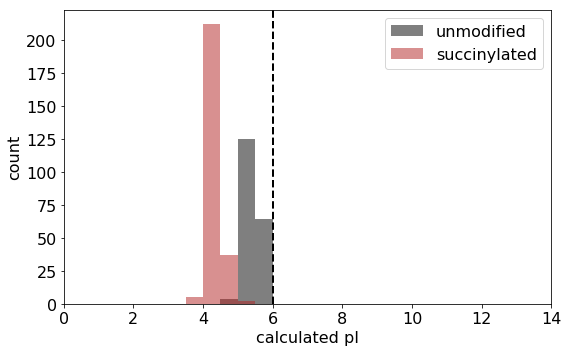

In [22]:
fig, ax = plt.subplots(figsize=(8,5))
native_pi = []
succ_pi = []
count = 0
for rs in rxn_syst.yield_rxn_syst(output_dir):  
    print('checking rxn', count, 'of', len(react_syst_files))
    count += 1
    # collect pIs of all sequences even if reaction is skipped elsewhere
    if rs.skip_rxn is True and rs.UniprotID != '' and rs.UniprotID != None:
        try:
            pI = rs.pI
        except AttributeError:
            print('calculating pI')
            IDs = rs.UniprotID.split(" ")
            total_sequence = ''
            for i in IDs:
                sequence = Uniprot_IO.get_sequence(i)
                total_sequence += sequence
            rs = pi_fn.calculate_rxn_syst_pI(total_sequence, rs, param_dict=param_dict)
            rs.save_object(output_dir+rs.pkl)
    
    if rs.UniprotID != '' and rs.UniprotID != None:
        if rs.req_mod == None:
            native_pi.append(rs.pI)
        else:
            succ_pi.append(rs.pI)
        
ax.hist(native_pi,
        facecolor='k',
        alpha=0.5,
        histtype='stepfilled',
        bins=np.arange(0, 14 + 0.2, 0.5),
        label='unmodified')

ax.hist(succ_pi,
        facecolor='firebrick',
        alpha=0.5,
        histtype='stepfilled',
        bins=np.arange(0, 14 + 0.2, 0.5),
        label='succinylated')

ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xlabel('calculated pI', fontsize=16)
ax.set_ylabel('count', fontsize=16)
ax.set_xlim(0, 14)
# plot pI cut-off
ax.axvline(x=param_dict['cutoff_pi'], c='k', lw='2', linestyle='--')
# legend
ax.legend(fontsize=16)

fig.tight_layout()
fig.savefig(output_dir+"pI_dist.pdf",
            dpi=720, bbox_inches='tight')

### Plot pI vs maximum component size

In [23]:
def define_plot_variables(ax, title, ytitle, xtitle, xlim, ylim):
    """
    Series of matplotlib pyplot settings to make all plots unitform.
    """
    # Set number of ticks for x-axis
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_xlabel(xtitle, fontsize=16)
    ax.set_ylabel(ytitle, fontsize=16)
    # ax.legend([y, n], ['aligned', 'not aligned'], loc=4, fancybox=True)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)


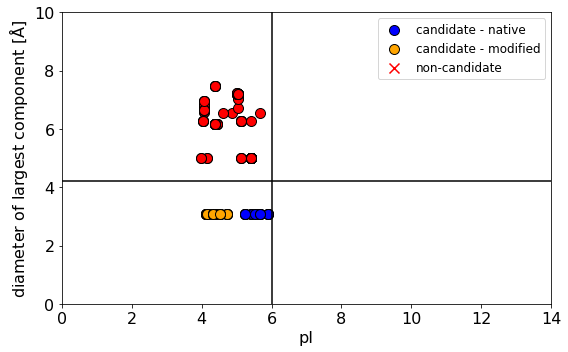

In [24]:
fig, ax = plt.subplots(figsize=(8,5))
# iterate over reaction system files
for rs in rxn_syst.yield_rxn_syst(output_dir):
    if rs.skip_rxn is True:
        continue
        
    if rs.seed_MOF is None:
        continue
    
    if rs.all_fit is True and rs.seed_MOF is True:
        M = 'o'
        if rs.req_mod is not None:
            C = 'orange'
        else:
            C = 'b'
        E = 'k'
    else:
        #if rs.pI < 6 or rs.max_comp_size < 4.2:
        #    print(rs.seed_MOF, rs.all_fit, rs.pkl, rs.pI, rs.max_comp_size)
        #    input('done')
        M = 'o'
        C = 'r'
        E = 'k'
        
    ax.scatter(rs.pI,
               rs.max_comp_size, c=C, 
               edgecolors=E, marker=M, alpha=1.0,
               s=100)
    
# decoy legend
ax.scatter(-100, 100,
           c='b', 
           edgecolors=E,
           marker='o', 
           alpha=1.0,
           s=100,
           label='candidate - native')
ax.scatter(-100, 100,
           c='orange',
           edgecolors=E,
           marker='o',
           alpha=1,
           s=100,
           label='candidate - modified')
ax.scatter(-100, 100,
           c='r',
           edgecolors=E,
           marker='x',
           alpha=1,
           s=100,
           label='non-candidate')

ax.legend(loc=1, fontsize=12)

ax.axhline(y=threshold, c='k')
ax.axvline(x=param_dict['cutoff_pi'], c='k')
define_plot_variables(ax,
                      title='',
                      xtitle='pI',
                      ytitle='diameter of largest component [$\mathrm{\AA}$]',
                      xlim=(0, 14),
                      ylim=(0, 10))
fig.tight_layout()
fig.savefig(output_dir+"size_vs_pI.pdf", dpi=720,
            bbox_inches='tight')

### Plot # of reactions vs threshold value

In [25]:
def define_plot_variables(ax, title, ytitle, xtitle, xlim, ylim):
    """
    Series of matplotlib pyplot settings to make all plots unitform.
    """
    # Set number of ticks for x-axis
    ax.tick_params(axis='both', which='major', labelsize=16)

    ax.set_xlabel(xtitle, fontsize=16)
    ax.set_ylabel(ytitle, fontsize=16)
    # ax.legend([y, n], ['aligned', 'not aligned'], loc=4, fancybox=True)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)


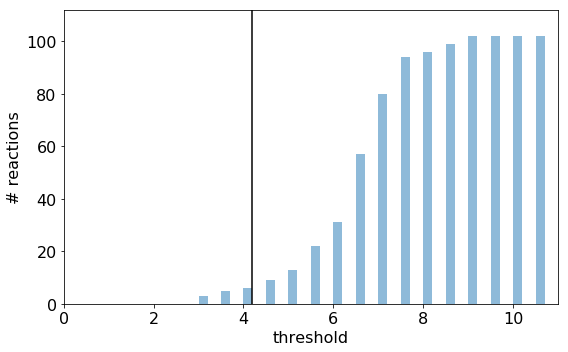

In [26]:
fig, ax = plt.subplots(figsize=(8,5))
max_sizes = []
reaction_reported = [] 
# iterate over reaction system files
for rs in rxn_syst.yield_rxn_syst(output_dir):
    if rs.skip_rxn is True:
        continue
    # get list of SMILES of all components
    r_smiles = []
    r_MW = []
    for r in rs.components:
        r_smiles.append(r.SMILES)
        r_MW.append(Descriptors.MolWt(r.mol))
    r_smiles = [x for _, x in sorted(zip(r_MW, r_smiles))]
    if r_smiles in reaction_reported:
        continue
    else:
        reaction_reported.append(r_smiles)
    try:
        if rs.max_comp_size > 0:
            max_sizes.append(rs.max_comp_size)
    except AttributeError:
        pass

    
max_sizes = np.asarray(max_sizes)
counts = []
threshs = np.arange(0.1, 21, 0.5)
for thr in threshs:
    count_above = len(max_sizes[max_sizes < thr])
    counts.append(count_above)
    
ax.bar(threshs, counts, align='center', alpha=0.5, width=0.2)

ax.axvline(x=threshold, c='k')

define_plot_variables(ax,
                      title='',
                      xtitle='threshold',
                      ytitle='# reactions',
                      xlim=(0, 11),
                      ylim=(0, max(counts)+10))
fig.tight_layout()
fig.savefig(output_dir+"size_vs_threshold.pdf", dpi=720,
            bbox_inches='tight')

### Categorize all molecules in output file

In [27]:
def define_plot_variables(ax, title, ytitle, xtitle, xlim, ylim):
    """
    Series of matplotlib pyplot settings to make all plots unitform.
    """
    # Set number of ticks for x-axis
    ax.tick_params(axis='both', which='major', labelsize=16)

    ax.set_ylabel(ytitle, fontsize=16)
    # ax.legend([y, n], ['aligned', 'not aligned'], loc=4, fancybox=True)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xticklabels(['diffuses', 'does not diffuse'])
    ax.set_xticks([0.25, 0.75])

In [28]:
molecule_output = DB_functions.initialize_mol_output_DF(mol_output_file, overwrite=False)

unique molecule that fits: H2O - DB: SABIO - ID: 40.0
unique molecule that fits: O2 - DB: SABIO - ID: 1264.0
unique molecule that fits: H2O2 - DB: SABIO - ID: 1909.0
unique molecule that fits: NH3 - DB: SABIO - ID: 1268.0
unique molecule that fits: CO2 - DB: SABIO - ID: 1266.0
unique molecule that fits: methanol - DB: BRENDA - ID: 17790.0
unique molecule that fits: formaldehyde - DB: BKMS - ID: 16842.0
unique molecule that fits: Ca2+ - DB: SABIO - ID: 1289.0
unique molecule that fits: CN- - DB: SABIO - ID: 2269.0
unique molecule that fits: dioxygen - DB: BKMS - ID: 15379.0
unique molecule that fits: thiocyanate - DB: BRENDA - ID: 18022.0
unique molecule that fits: chloride - DB: BRENDA - ID: 17996.0
unique molecule that fits: hypochlorous acid - DB: BRENDA - ID: 24757.0
unique molecule that fits: superoxide - DB: BKMS - ID: 18421.0
unique molecule that fits: hydron - DB: BKMS - ID: 15378.0
unique molecule that fits: bromide - DB: BKMS - ID: 15858.0
unique molecule that fits: hypobromou

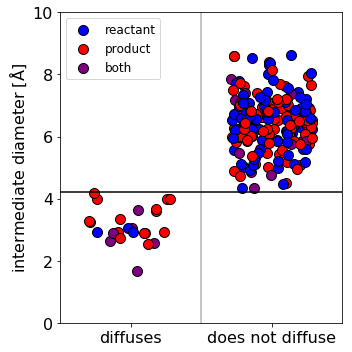

In [29]:
dx = 0.15
fig, ax = plt.subplots(figsize=(5,5))
for idx, row in molecule_output.iterrows():
    mid_diam = row['mid_diam']
    if mid_diam == 0:
        continue
    if mid_diam <= threshold:
        M = 'o'
        E = 'k'
        D = 0.25
        print('unique molecule that fits:', row['name'], 
              '- DB:', row['DB'], '- ID:', row['DB_ID'])
    else:
        M = 'o'
        E = 'k'
        D = 0.75
    
    # set colour based on role
    if row['role'] == 'reactant':
        C = 'b'
    elif row['role'] == 'product':
        C = 'r'
    elif row['role'] == 'both':
        C = 'purple'
    
    ax.scatter(D+(dx*(np.random.random() - 0.5) * 2),
               mid_diam, c=C, 
               edgecolors=E, marker=M, alpha=1.0,
               s=100)
    
# decoy legend
ax.scatter(-100, 100,
           c='b', 
           edgecolors=E, marker='o', alpha=1.0,
           s=100,
           label='reactant')
ax.scatter(-100, 100,
           c='r', 
           edgecolors=E, marker='o', alpha=1.0,
           s=100,
           label='product')
ax.scatter(-100, 100,
           c='purple', 
           edgecolors=E, marker='o', alpha=1.0,
           s=100,
           label='both')

ax.legend(loc=2, fontsize=12)

ax.axhline(y=threshold, c='k')
ax.axvline(x=0.5, c='k', alpha=0.3)
define_plot_variables(ax,
                      title='',
                      xtitle='',
                      ytitle='intermediate diameter [$\mathrm{\AA}$]',
                      xlim=(0, 1),
                      ylim=(0, 10))
fig.tight_layout()
fig.savefig(output_dir+"categorical.pdf", dpi=720,
            bbox_inches='tight')

In [30]:
molecule_output

,name,iupac_name,DB,DB_ID,SMILE,role,min_diam,mid_diam,max_diam,ratio_1,ratio_2
0,H2O,oxidane,SABIO,40.0,O,both,2.492,2.586,3.748,0.347,0.653
1,O2,Molecular oxygen,SABIO,1264.0,[O],both,2.635,2.639,2.675,0.000,0.000
2,H2O2,hydrogen peroxide,SABIO,1909.0,OO,both,2.767,3.070,4.138,0.101,0.984
3,NH3,azanide,SABIO,1268.0,N,product,2.702,2.928,3.475,0.636,0.636
4,Urea,UREA,SABIO,1798.0,N=C(N)O,reactant,2.908,5.012,5.671,0.446,0.554
5,CO2,carbon dioxide,SABIO,1266.0,O=C=O,product,2.757,2.898,5.388,0.000,1.000
6,sucrose,"(2R,3R,4S,5S,6R)-2-[(2S,3S,4S,5R)-3,4-dihydrox...",KEGG,17992.0,OCC1OC(OC2(CO)OC(CO)C(O)C2O)C(O)C(O)C1O,reactant,0.000,0.000,0.000,0.000,0.000
7,beta-D-fructofuranose,"(2R,3S,4S,5R)-2,5-bis(hydroxymethyl)oxolane-2,...",KEGG,28645.0,O[CH2:1][C@@:2]1(O)O[C@H:5]([CH2:6]O)[C@@H:4](...,product,5.364,7.017,8.523,0.498,0.682
8,alpha-D-glucose,"6-(hydroxymethyl)oxane-2,3,4,5-tetrol",KEGG,17925.0,O[C@H:1]1O[C@H:5]([CH2:6]O)[C@@H:4](O)[C@H:3](...,both,4.862,7.193,8.328,0.444,0.734
9,raffinose,"(2R,3R,4S,5S,6R)-2-[(2S,3S,4S,5R)-3,4-dihydrox...",BKMS,16634.0,OC[C@H]1O[C@@](CO)(O[C@H]2O[C@H](CO[C@H]3O[C@H...,both,0.000,0.000,0.000,0.000,0.000


### print all reactions that fit

In [31]:
reaction_reported = []
# iterate over reaction system files
for rs in rxn_syst.yield_rxn_syst(output_dir):
    if rs.skip_rxn is True:
        continue
    # get list of SMILES of all components
    r_smiles = []
    r_MW = []
    for r in rs.components:
        r_smiles.append(r.SMILES)
        r_MW.append(Descriptors.MolWt(r.mol))
    r_smiles = [x for _, x in sorted(zip(r_MW, r_smiles))]
    if r_smiles in reaction_reported:
        continue
    else:
        reaction_reported.append(r_smiles)
    if rs.all_fit is True:
        count += 1
        print("New Reaction:")
        rs.print_rxn_system()
        
print("There are", count, "new reactions!")

New Reaction:
-----------------------------------
EC: 1.11.1.6
Database: SABIO
Database ID: 23680
-----------------------------------
H2O  (ID: 40) as product
SMILES: O
O2  (ID: 1264) as product
SMILES: [O]
H2O2  (ID: 1909) as reactant
SMILES: OO
-----------------------------------
All components will diffuse through!
-----------------------------------
New Reaction:
-----------------------------------
EC: 1.11.1.6
Database: BKMS
Database ID: 8219
-----------------------------------
hydrogen peroxide  (ID: 16240) as reactant
SMILES: OO
methanol  (ID: 17790) as reactant
SMILES: CO
formaldehyde  (ID: 16842) as product
SMILES: C=O
water  (ID: 15377) as product
SMILES: O
-----------------------------------
All components will diffuse through!
-----------------------------------
New Reaction:
-----------------------------------
EC: 1.11.1.7
Database: BRENDA
Database ID: BR59
-----------------------------------
chloride  (ID: 17996) as reactant
SMILES: [Cl-]
hydrogen peroxide  (ID: 16240) as

## Timing Information

#### pI screening - all sequences in BRENDA

(0, 30000)

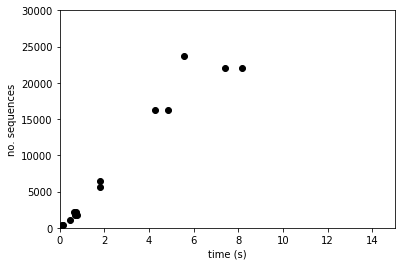

In [32]:
times = [0.74, 8.18, 4.85, 0.13, 0.02, 0.78, 
         0.62, 7.42, 4.26, 0.11, 0.01, 0.67, 
         300.89, 1.81, 0.03, 1.82, 0.44, 5.56]
seqs = [2220, 22068, 16288, 379, 36, 1765, 2220,
        22068, 16288, 379, 36, 1765, 1253592,
        6487, 80, 5665, 1098, 23660]
plt.scatter(times, seqs, c='k')
plt.xlabel('time (s)')
plt.ylabel('no. sequences')
plt.xlim(0, 15)
plt.ylim(0, 30000)

#### molecule screening

In [34]:
print('time taken to do molecule screening:')
print('collect reaction systems:', 1*60*60 + 47*60 + 34, 's')
print('accessibility:', 1*60*60 + 0*60 + 49, 's')
print('pI analysis:', 0*60*60 + 7*60 + 55, 's')
print('total:', 2*60*60 + 54*60 + 34 + 49 + 55, 's ==', (2*60*60 + 54*60 + 34 + 49 + 55) / 60 / 60, 'h')

time taken to do molecule screening:
collect reaction systems: 6454 s
accessibility: 3649 s
pI analysis: 475 s
total: 10578 s
